# 1. Árbol de decisión para clasificación

**Objetivo:** entrenar y probar un modelo de árbol de decisión para clasificar tipo de uso de suelo a partir de imágenes satelitales.


Este dataset es usado para clasificar el uso de suelo en imágenes geoespaciales. 
https://www.kaggle.com/apollo2506/eurosat-dataset

**Información de las características**
Este dataset contiene imágenes que pertenecen all dataset de EuroSat. Hay 10 folders:
* 0 AnnualCrop
* 1 Forest
* 2 HerbaceousVegatation
* 3 Highway
* 4 Industrial
* 5 Pasture
* 6 PermanentCrop
* 7 Residential
* 8 River
* 9 SeaLake


**Número de instancias:** 27000

# 2. Autenticación a Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 3. Importando librerías

In [ ]:
import pandas as pd
import os
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import cv2
import random
import seaborn as sns

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

# 4. Lectura del archivo

In [ ]:
path = r'/content/drive/Shareddrives/Data Science para Geociencias/6. Métodos de ML/6.3 Árbol de decisión'
train_path = os.path.join(path,'EUROSAT_TRAIN_FEAT.csv')
test_path = os.path.join(path,'EUROSAT_TEST_FEAT.csv')
val_path = os.path.join(path,'EUROSAT_VAL_FEAT.csv')

In [ ]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
val_df = pd.read_csv(val_path)
clases = train_df['label'].unique()
val_df.dropna(axis=0, inplace=True)
val_df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (532) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,histogram_0,histogram_1,histogram_2,histogram_3,histogram_4,histogram_5,histogram_6,histogram_7,histogram_8,histogram_9,histogram_10,histogram_11,histogram_12,histogram_13,histogram_14,histogram_15,histogram_16,histogram_17,histogram_18,histogram_19,histogram_20,histogram_21,histogram_22,histogram_23,histogram_24,histogram_25,histogram_26,histogram_27,histogram_28,histogram_29,histogram_30,histogram_31,histogram_32,histogram_33,histogram_34,histogram_35,histogram_36,histogram_37,histogram_38,histogram_39,...,histogram_493,histogram_494,histogram_495,histogram_496,histogram_497,histogram_498,histogram_499,histogram_500,histogram_501,histogram_502,histogram_503,histogram_504,histogram_505,histogram_506,histogram_507,histogram_508,histogram_509,histogram_510,histogram_511,hal_0,hal_1,hal_2,hal_3,hal_4,hal_5,hal_6,hal_7,hal_8,hal_9,hal_10,hal_11,hal_12,hum_0,hum_1,hum_2,hum_3,hum_4,hum_5,hum_6,label
0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012994,7.251687,0.569645,8.429464,0.375006,115.509885,26.466171,4.374186,6.767082,0.002471,2.615471,-0.093455,0.683802,0.002873,3.509016e-10,2.146800e-13,1.402699e-12,-2.872049e-25,-2.314543e-17,7.141490e-25,Forest
1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018296,5.842052,0.816599,15.943187,0.441443,123.407684,57.930697,4.424694,6.525627,0.002418,2.437066,-0.177934,0.845006,0.002707,1.700231e-09,1.333079e-11,2.423838e-12,-6.958007e-24,8.597742e-17,1.189189e-23,Forest
2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010315,10.652760,0.537951,11.534615,0.341351,92.588758,35.485698,4.576100,7.214955,0.002523,2.843523,-0.091416,0.689215,0.003626,1.035725e-10,2.678465e-11,2.766547e-12,2.133885e-23,-2.734900e-17,-1.057385e-23,Forest
3,0.0,0.0,0.004063,0.000451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002744,21.673853,0.858303,76.466275,0.294396,138.624197,284.191247,6.009713,8.986742,0.001166,3.273094,-0.234898,0.950733,0.002411,5.041927e-09,3.428702e-12,4.190876e-11,3.790570e-22,2.576051e-15,-3.296810e-22,Forest
4,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018016,4.368246,0.727247,8.003737,0.475602,137.192686,27.646703,4.358600,6.299226,0.002541,2.229800,-0.183273,0.842506,0.002428,8.157395e-11,1.160273e-13,1.039598e-12,3.534865e-25,-9.291471e-18,-7.355809e-26,Forest


# 5. Exploración de datos (EDA)

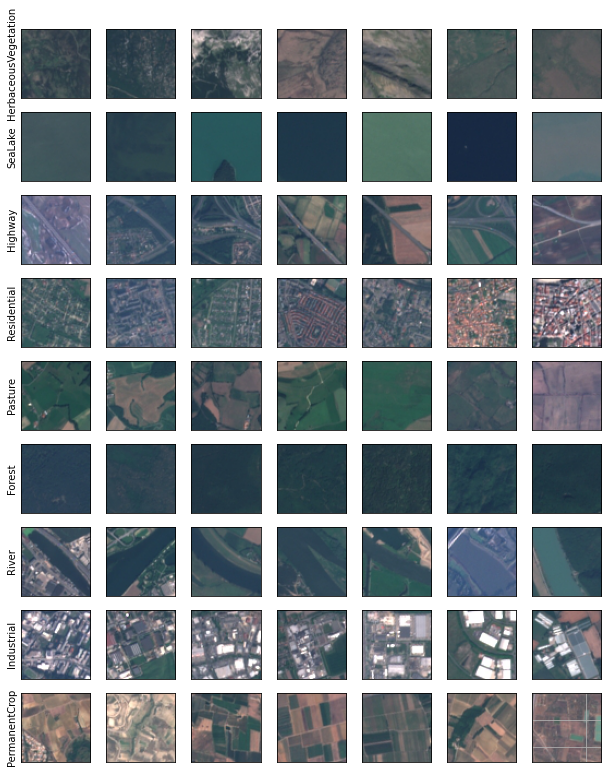

In [ ]:
train_path_or = r"/content/drive/My Drive/EUROSAT/train"
folders = os.listdir(train_path_or)

plt.figure(figsize=(15,15))
for i,folder in enumerate(folders):
    path_folder = os.path.join(train_path_or, folder)
    imgs_list =os.listdir(path_folder)
    random.shuffle(imgs_list)
    for j in range(7):
        img_path = os.path.join(path_folder,imgs_list[j])
        plt.subplot(10,10,i*10+j+1)
        img = plt.imread(img_path)
        plt.imshow(img)
        #plt.axis("off")
        plt.tick_params(axis='both',which='both', bottom=False, top=False, left=False, right=False,
                        labelbottom=False, labelleft=False)
        if j==0:
            plt.ylabel(folder)
plt.grid('off')
plt.show()

# 6. Limpieza de datos

#### a) Escalamiento

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_df.loc[:, train_df.columns != 'label'] = scaler.fit_transform(train_df.loc[:, train_df.columns != 'label'])

In [ ]:
test_df.loc[:, test_df.columns != 'label'] = scaler.transform(test_df.loc[:, test_df.columns != 'label'])
val_df.loc[:, val_df.columns != 'label'] = scaler.transform(val_df.loc[:, val_df.columns != 'label'])

#### b) Codificación de etiquetas

In [ ]:
le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df.label.values)

In [ ]:
test_df['label'] = le.transform(test_df.label.values)
val_df['label'] = le.transform(val_df.label.values)

### c) Selección de características

In [ ]:
fs = SelectKBest(score_func=f_classif, k=50)
np_X = train_df.iloc[:,:-1].to_numpy()
np_Y = train_df.iloc[:,-1].to_numpy()
X_selec = fs.fit_transform(np_X, np_Y)
attr_names = train_df.columns.values.tolist()
# Lista de bools que indican si es un atributo seleccionado o no
mask = fs.get_support()
# Lista de los K mejores atributos
new_features = [] 
for bool, feature in zip(mask, attr_names):
    if bool:
        new_features.append(feature)
new_train_df = pd.DataFrame(X_selec, columns=new_features)
new_train_df['label'] = train_df['label']

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  0   8  16  24  33  40  41  43  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  72  80  88  91  94  95  96  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 128 136 144 160 168 175 177
 180 181 182 183 184 185 186 187 188 189 190 191 192 200 216 224 232 240
 244 245 246 247 248 249 250 251 252 253 254 255 256 264 280 285 286 287
 288 289 291 292 293 294 295 296 298 299 300 301 302 303 305 306 307 308
 309 310 311 312 313 314 315 316 317 318 319 320 328 336 344 352 353 354
 360 361 362 363 365 368 369 370 371 372 373 374 375 376 377 378 379 380
 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398
 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416
 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434
 435 43

In [ ]:
new_test_df = test_df[new_features].copy()
new_test_df['label'] = test_df['label']

In [ ]:
new_val_df = val_df[new_features].copy()
new_val_df['label'] = val_df['label']

# 7. Modelo de árbol de decisión CART usando Holdout validation


a) Transformación de data frames a arreglos de numpy

In [ ]:
Xtrain = new_train_df.iloc[:,:-1].to_numpy() 
Xtest = new_test_df.iloc[:,:-1].to_numpy() 
Ytrain = new_train_df.iloc[:,-1].to_numpy() 
Ytest = new_test_df.iloc[:,-1].to_numpy() 

b) Binarizando las etiquetas de clases con la codificación One-Hot

In [ ]:
seed = 10

In [ ]:
n_classes = 9

c) Instanciando un árbol de decisión

In [ ]:
dectree = DecisionTreeClassifier(random_state=seed)

d) Ajustando el árbol con los datos de entrenamiento

In [ ]:
dectree = dectree.fit(Xtrain,Ytrain)#y_train_bin)

# 8. Prediciendo para los datos de prueba

In [ ]:
y_pred = dectree.predict(Xtest)

a) Calculando el rendimiento general del modelo

In [ ]:
score = metrics.accuracy_score(Ytest, y_pred)
print("Test Acc: %s"%score)

Test Acc: 0.8041666666666667


b) Predicciones vs etiquetas verdaderas

In [ ]:
predictions = np.float32(y_pred)
true_labels = np.float32(Ytest)

c) Matriz de confusión para evaluar los errores

In [ ]:
def plot_confusion_matrix(cm, classes, tit, normalize=False):
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)
        title, fmt = 'Matriz de confusión normalizada', '.2f'
    else:
        title, fmt = tit, 'd'
    plt.figure(figsize=(10,8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)#, fontsize=12)
    plt.colorbar(pad=0.05)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=40)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Clase Verdadera')#, fontsize=10)
    plt.xlabel('Clase Predicha')#, fontsize=10)
    plt.savefig(title+'.png')
    #plt.grid(b=None)
    plt.show()

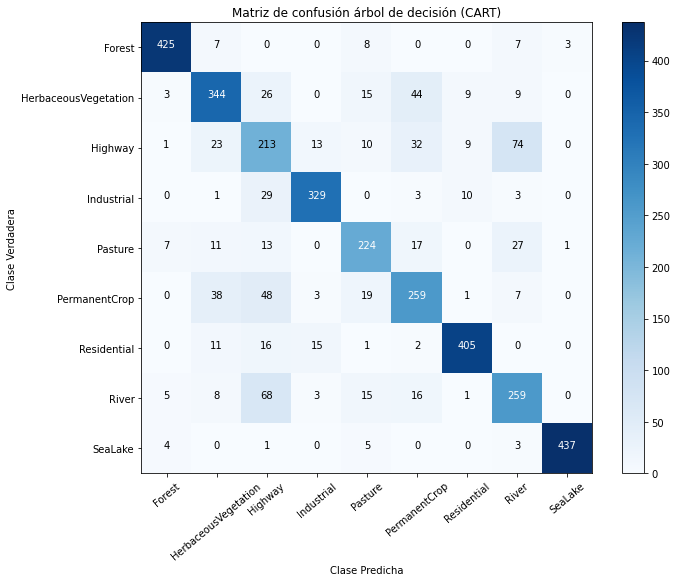

In [ ]:
cnf_matrix = confusion_matrix(true_labels, predictions, labels=range(n_classes))
tit = 'Matriz de confusión árbol de decisión (CART)'
plot_confusion_matrix(cnf_matrix,clases, tit, normalize=False)

e) Otras métricas para evaluar el rendimiento

In [ ]:
def sens_spec(cls_names, y_true, y_pred, pesos):
  sensitivity = []
  specificity = []
  prec=[]
  fscore = []
  sd = []
  for i,name in enumerate(cls_names):
    TP = np.sum((y_true==name) & (y_pred==name))
    TN = np.sum((y_true!=name) & (y_pred!=name))
    FP = np.sum((y_true!=name) & (y_pred==name))
    FN = np.sum((y_true==name) & (y_pred!=name))
    sensitivity.append(TP/(TP+FN))
    specificity.append(FP/(TN+FP))
    prec.append(TP/(TP+FP))
    fscore.append(2*(prec[i]*sensitivity[i])/(prec[i]+sensitivity[i]))
  sensitivity.append(sum([x*y for x,y in zip(sensitivity,pesos)]))
  specificity.append(sum([x*y for x,y in zip(specificity,pesos)]))
  prec.append(sum([x*y for x,y in zip(prec,pesos)]))
  fscore.append(sum([x*y for x,y in zip(fscore,pesos)]))
  for i in range(len(cls_names)):
    sd.append(np.sqrt((sensitivity[i]-sensitivity[-1])**2))
  sd.append(np.nan)
  return sensitivity, specificity, prec, fscore, sd

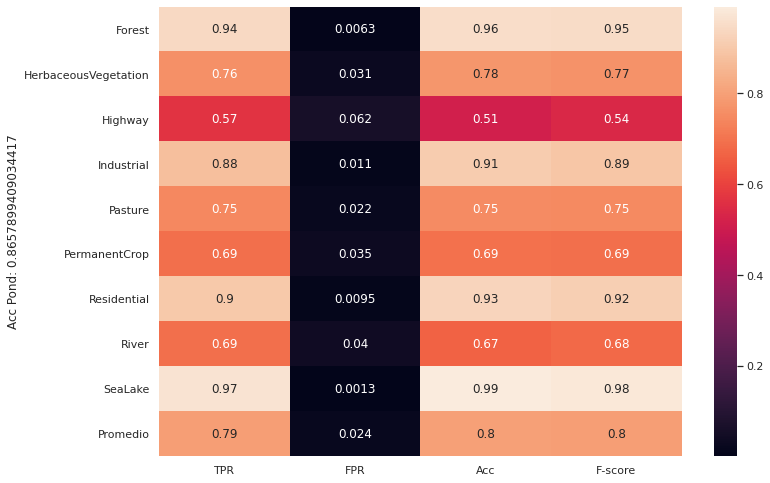

In [ ]:
sensitivity, FPR, prec, fscore, sd = sens_spec(range(n_classes), true_labels, predictions, [1.0/9]*9)
d = {'TPR':sensitivity, 'FPR':FPR, 'Acc':prec, 'F-score':fscore}
ind = clases.tolist()+['Promedio']
df = pd.DataFrame(d, index=ind)#.transpose()
index = df.index
precprom=prec[0]*0.5+prec[1]*0.5
index.name = 'Acc Pond: %s'%precprom
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(df, annot=True)